In [34]:
import numpy as np
from matplotlib import pyplot as plt
#from plot_parameters import FONT_SIZE, LEGEND_SIZE, FONT,  figsize
from noise_formulas import NEP_g, NEP_ph, S_I

figsize=(10,8)
#%run ../utils/python_utils.py
%run ../../plot_parameters.py

In [35]:
# Read LiteBIRD detector parameters (reported on PTEP) from text file
v, dvfrac, popt, psat, tc, n  = np.loadtxt('LiteBIRD_PTEP_bolo_params.txt', skiprows=3, delimiter=',', dtype=float, usecols=(1,2,3,4,5,6), unpack=True)
dv = dvfrac*v
tb = 0.1

In [36]:
# calculate other noise sources
nep_g = NEP_g(psat, n, tb, tc) # phonon noise
nep_ph = NEP_ph(popt, v, dv) # photon noise

In [37]:
nep_read_req = np.sqrt((nep_g**2 + nep_ph**2)*(1.1**2-1))
rtes = np.array([1., 0.8, 0.7])
loopgain = 10
si = S_I(rtes[:, np.newaxis], psat-popt, loopgain)
nei_read_req = nep_read_req*si

In [38]:
for r, rt in enumerate(rtes):
    min_noise = np.min(nei_read_req[r, :])
    print("{:2f} pA/sqrt(Hz)".format(min_noise*1e12))

6.199155 pA/sqrt(Hz)
6.930866 pA/sqrt(Hz)
7.409408 pA/sqrt(Hz)


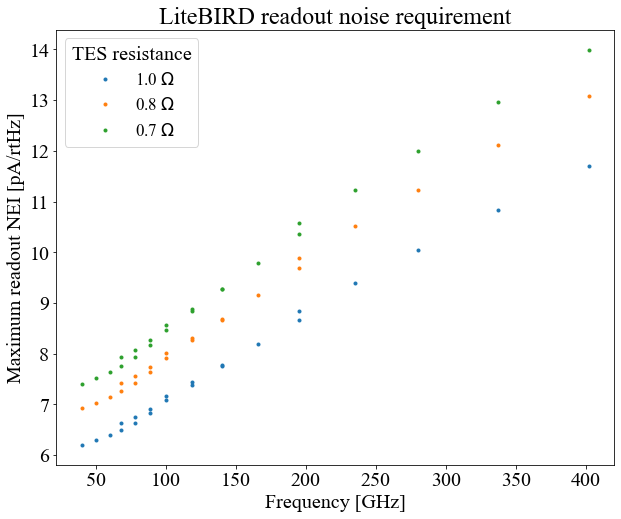

In [39]:
plt.figure(1, figsize=figsize)
plt.plot(v/1e9, nei_read_req[0]*1e12, '.', label=f'{rtes[0]} $\Omega$')
plt.plot(v/1e9, nei_read_req[1]*1e12, '.', label=f'{rtes[1]} $\Omega$')
plt.plot(v/1e9, nei_read_req[2]*1e12, '.', label=f'{rtes[2]} $\Omega$')
plt.xlabel('Frequency [GHz]')
plt.ylabel('Maximum readout NEI [pA/rtHz]')
plt.title('LiteBIRD readout noise requirement')
plt.legend(title='TES resistance')
plt.show()

### See how this compares to achieved readout


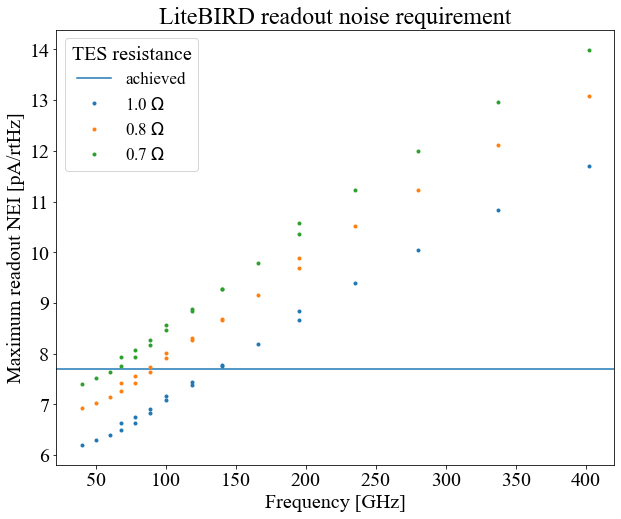

Rtes [ohms]    |    Achieved NEI / Min Required NEI 
   1.00        |               1.24  
   0.80        |               1.11  
   0.70        |               1.04  


In [40]:
# In terms of NEI
NEI_achieved = 7.7e-12 # A/sqrt(Hz) from an old presentation from Tucker

plt.figure(1, figsize=figsize)
plt.axhline(NEI_achieved*1e12, label="achieved")
plt.plot(v/1e9, nei_read_req[0]*1e12, '.', label=f'{rtes[0]} $\Omega$')
plt.plot(v/1e9, nei_read_req[1]*1e12, '.', label=f'{rtes[1]} $\Omega$')
plt.plot(v/1e9, nei_read_req[2]*1e12, '.', label=f'{rtes[2]} $\Omega$')
plt.xlabel('Frequency [GHz]')
plt.ylabel('Maximum readout NEI [pA/rtHz]')
plt.title('LiteBIRD readout noise requirement')
plt.legend(title='TES resistance')
plt.show()


#print("Minimum NEI required: %.1f pA/sqrt(Hz) " %(np.min(nei_read_req[rc])*1e12 ))

print("Rtes [ohms]    |    Achieved NEI / Min Required NEI ")
for rc, r in enumerate(rtes):
    print("   %.2f        |               %.2f  " %(r, NEI_achieved / np.min(nei_read_req[rc])))

## In terms of NEP

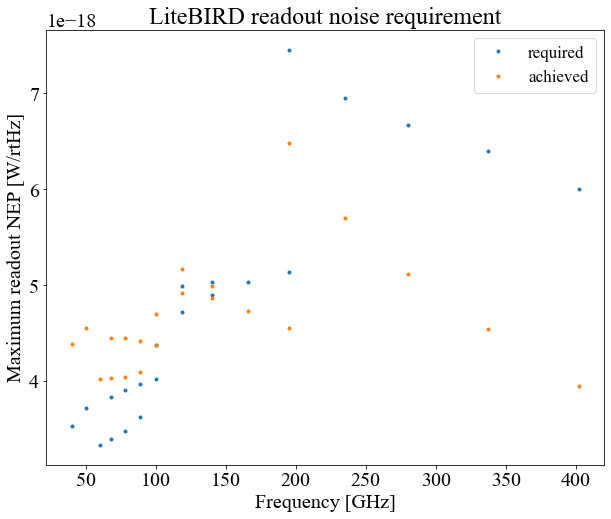

In [41]:
#nep_read_req
#nei_read_req = nep_read_req*si

nep_read_achieved = NEI_achieved /(si[0]) # selecting resistance of 1 ohm and lowest frequency band
#print(nep_read_achieved)
#print("Responsivity: ", si[0][0])
yscale = 1 #  Watts

plt.figure(figsize=figsize)
plt.plot(v/1e9, nep_read_req*yscale, '.', label="required")
#plt.axhline( nep_read_achieved*yscale, label="achieved")
plt.plot( v/1e9, nep_read_achieved*yscale, '.', label="achieved")
plt.xlabel('Frequency [GHz]')
plt.ylabel('Maximum readout NEP [W/rtHz]')
plt.title('LiteBIRD readout noise requirement')
plt.legend()
plt.show()